In [1]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Read files

In [2]:
img_shape = (376, 256)

def get_files(x): return [os.path.join(x,f) for f in os.listdir(x) if f[0]!='.']

def load_data(path):
    img_files = get_files(os.path.join(path,'image'))
    label_files = [f for f in get_files(os.path.join(path,'label')) if f[-4:]=='.npy']
    assert len(img_files) == len(label_files)
    imgs = np.zeros((len(img_files),*img_shape,3), np.float32)
    labels = np.zeros((len(img_files),*img_shape,5), np.float32)
    label_files_out = []
    for i,f in enumerate(img_files):
        name = os.path.basename(f).split('.')[0]
        label = [l for l in label_files if name in l][0]
        label_files_out.append(label)
        img = Image.open(f)
        img = img.resize(img_shape[::-1])
        imgs[i] = np.asarray(img).astype(np.float32)
        lbl = np.load(label).astype(np.float32)
        labels[i] = cv2.resize(lbl, img_shape[::-1])
    
    return imgs, labels, (img_files, label_files_out)

In [3]:
train_imgs, train_labels, train_files = load_data('unetParzivalData/train/')
train_imgs.shape, train_labels.shape

((24, 376, 256, 3), (24, 376, 256, 5))

# Preprocess

In [4]:
pp_mean = train_imgs.mean((0,1,2))
pp_std = train_imgs.std((0,1,2))
def apply_pp(x): return (x-pp_mean)/pp_std
train_imgs = apply_pp(train_imgs)
pp_mean, pp_std

(array([ 183.39016724,  171.22546387,  142.59970093], dtype=float32),
 array([ 63.42814636,  62.97451019,  58.44029617], dtype=float32))

In [5]:
# Load validation data
val_imgs, val_labels, val_files = load_data('unetParzivalData/validation/')
val_imgs = apply_pp(val_imgs)
val_imgs.shape, val_labels.shape

((2, 376, 256, 3), (2, 376, 256, 5))

In [6]:
# Load test data
test_imgs, test_labels, test_files = load_data('unetParzivalData/test/')
test_imgs = apply_pp(test_imgs)
test_imgs.shape, test_labels.shape

((13, 376, 256, 3), (13, 376, 256, 5))

# Model

In [7]:
from keras.layers import Input, Dropout, BatchNormalization, Concatenate, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [8]:
def conv_layer(x, f, k=3, s=1, p='same', act='relu', bn=False, transpose=False):
    k_init = 'he_uniform' if act == 'relu' else 'glorot_uniform'
    out = Conv2D(f, k, strides=s, padding=p, use_bias=False, kernel_initializer=k_init)(x)
    if bn: out = BatchNormalization()(out)
    if act is not None: out = Activation(act)(out)

    return out

def build_model():
    x_in = Input((*img_shape, 3))
    
    # Encoder
    enc1 = conv_layer(x_in, 64)
    enc1 = conv_layer(enc1, 64)
    pool1 = MaxPool2D()(enc1)
    
    enc2 = conv_layer(pool1, 128)
    enc2 = conv_layer(enc2, 128)
    pool2 = MaxPool2D()(enc2)
        
    enc3 = conv_layer(pool2, 256)
    enc3 = conv_layer(enc3, 256)
    pool3 = MaxPool2D()(enc3)
        
    enc4 = conv_layer(pool3, 512)
    enc4 = conv_layer(enc4, 512)
    drop4 = Dropout(0.5)(enc4)

    
    # Decoder
    dec1 = conv_layer(UpSampling2D()(drop4), 256)
    dec1 = Concatenate()([enc3, dec1])
    dec1 = conv_layer(dec1, 256)
    
    dec2 = conv_layer(UpSampling2D()(dec1), 128)
    dec2 = Concatenate()([enc2, dec2])
    dec2 = conv_layer(dec2, 128)
    
    dec3 = conv_layer(UpSampling2D()(dec2), 128)
    dec3 = Concatenate()([enc1, dec3])
    dec3 = conv_layer(dec3, 128)
    
    # Out
    out = conv_layer(dec3, 64)
    out = conv_layer(out, 5, 1, act='sigmoid')
    
    model = Model(x_in, out)
    return model

In [9]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 376, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 376, 256, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 376, 256, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 376, 256, 64) 36864       activation_1[0][0]               
__________________________________________________________________________________________________
activation

# Train

In [10]:
lr = 1e-4
bs = 8

In [11]:
model.compile(Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
h = model.fit(train_imgs, train_labels, bs, 10,
              validation_data=(val_imgs, val_labels))

Train on 24 samples, validate on 2 samples
Epoch 1/10
24/24 [==============================] - 5s 219ms/step - loss: 0.4836 - acc: 0.7295 - val_loss: 0.3173 - val_acc: 0.8669
Epoch 2/10
24/24 [==============================] - 1s 58ms/step - loss: 0.3056 - acc: 0.8557 - val_loss: 0.2178 - val_acc: 0.9110
Epoch 3/10
24/24 [==============================] - 1s 58ms/step - loss: 0.2225 - acc: 0.9066 - val_loss: 0.1738 - val_acc: 0.9331
Epoch 4/10
24/24 [==============================] - 1s 58ms/step - loss: 0.1955 - acc: 0.9289 - val_loss: 0.1604 - val_acc: 0.9419
Epoch 5/10
24/24 [==============================] - 1s 58ms/step - loss: 0.1870 - acc: 0.9307 - val_loss: 0.2079 - val_acc: 0.9260
Epoch 6/10
24/24 [==============================] - 1s 58ms/step - loss: 0.1757 - acc: 0.9322 - val_loss: 0.1413 - val_acc: 0.9478
Epoch 7/10
24/24 [==============================] - 1s 58ms/step - loss: 0.1643 - acc: 0.9333 - val_loss: 0.1545 - val_acc: 0.9471
Epoch 8/10
24/24 [=====================

In [13]:
model.evaluate(test_imgs, test_labels, bs)

13/13 [==============================] - 1s 63ms/step


[0.28571433058151829, 0.89183118251653815]

# Results on test

In [28]:
idx = np.random.choice(len(test_imgs))
idx

3

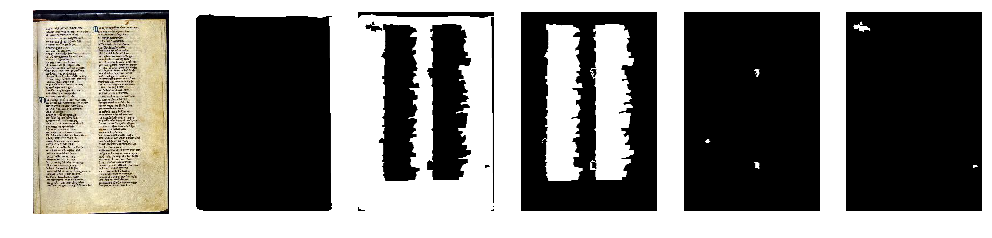

In [29]:
# True
src = np.asarray(Image.open(test_files[0][idx]))
fig, ax = plt.subplots(1, 6, figsize=(17,5))
ax[0].imshow(src)
for c in range(5):
    ax[c+1].imshow(test_labels[idx,:,:,c], 'gray')
for axx in ax: axx.set_axis_off()

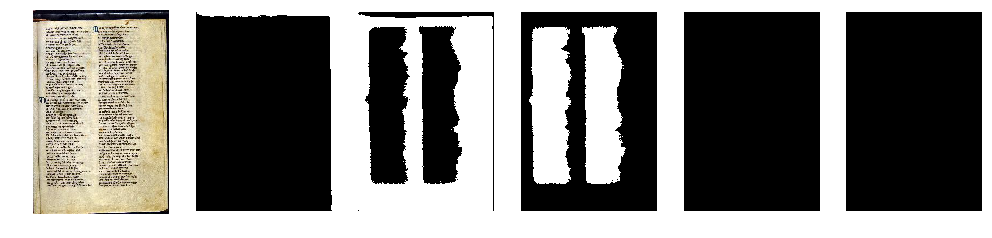

In [30]:
# Model
src = np.asarray(Image.open(test_files[0][idx]))
res = model.predict(test_imgs[idx][None])[0]
fig, ax = plt.subplots(1, 6, figsize=(17,5))
ax[0].imshow(src)
for c in range(5):
    ax[c+1].imshow(res[:,:,c] > .5, 'gray')
for axx in ax: axx.set_axis_off()